**Import libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import LSTM, Conv1D, Activation, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras import callbacks
import keras

sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")

from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

2024-06-09 09:38:53.607933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 09:38:53.608041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 09:38:53.713748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_24/2605061694.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_2

In [2]:
# Reading data
pjme = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv',index_col=[0], parse_dates=[0])

In [3]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
pjme.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


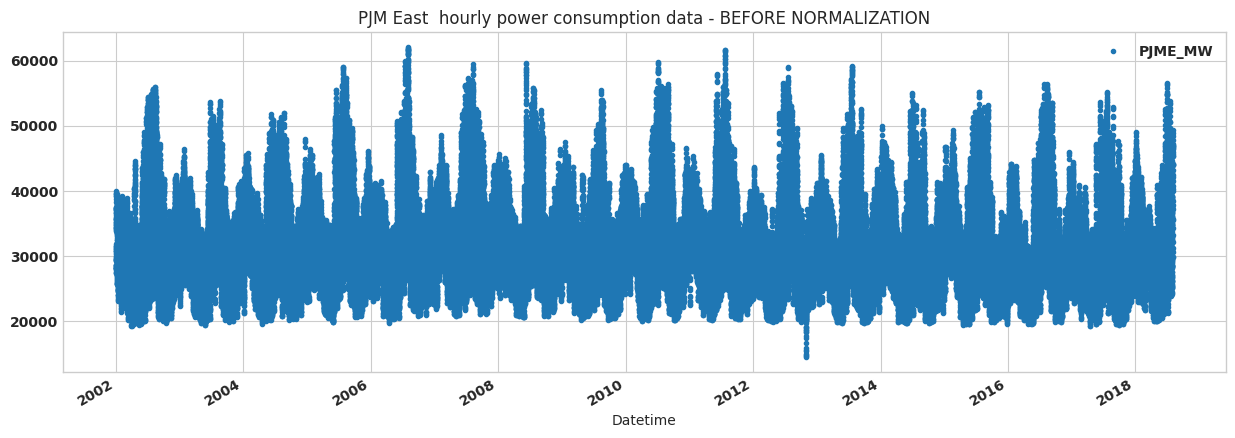

In [5]:
pjme.plot(style='.', figsize=(15,5), title='PJM East  hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [6]:
import sklearn
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['PJME_MW']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    return df

pjme = normalize_data(pjme)
pjme.shape

(145366, 1)

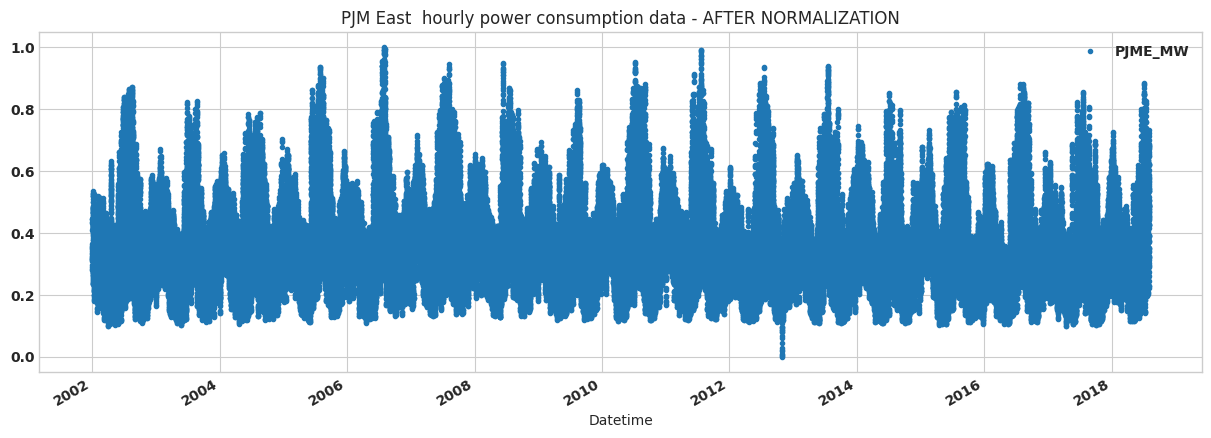

In [7]:
pjme.plot(style='.', figsize=(15,5), title='PJM East  hourly power consumption data - AFTER NORMALIZATION' )
plt.show()

**splitting data**

In [8]:
split_date = '01-Jan-2016'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

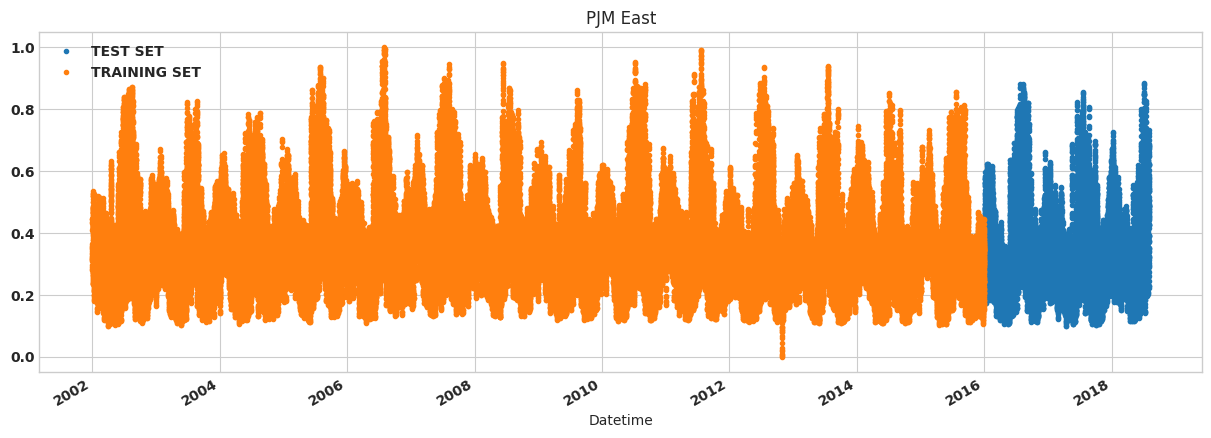

In [9]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

In [10]:
def load_data(train,test, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(train)):
        X_train.append(train.iloc[i-seq_len : i, 0])
        y_train.append(train.iloc[i, 0])
    
    X_test = []
    y_test = []
    for i in range(seq_len, len(test)):
        X_test.append(test.iloc[i-seq_len : i, 0])
        y_test.append(test.iloc[i, 0])
   
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [11]:
#create train, test data
seq_len = 20 

X_train, y_train, X_test, y_test = load_data(pjme_train , pjme_test , seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (122667, 20, 1)
y_train.shape =  (122667,)
X_test.shape =  (22659, 20, 1)
y_test.shape =  (22659,)


# **Building Models**

**AttentionCNN**

In [12]:
class Attention(layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        query = tf.matmul(inputs, self.W) + self.b
        query = tf.nn.tanh(query)
        score = tf.reduce_sum(tf.multiply(query, self.V), axis=2)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(tf.multiply(inputs, tf.expand_dims(attention_weights, axis=-1)), axis=1)
        return context_vector

In [13]:
inputs_1 = layers.Input(shape=(X_train.shape[1], 1))
x = layers.LSTM(64, return_sequences=True)(inputs_1)
x = Attention(units=32)(x)

x = Conv1D(128, 5)(inputs_1)
x = Activation('relu')(x)

x = Conv1D(64, 5)(x)
x = Activation('relu')(x)

x = Conv1D(32, 5)(x)
x = Activation('relu')(x)

x = Flatten()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

outputs = Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=inputs_1, outputs=outputs)

In [14]:
# Set the learning rate
learning_rate = 0.001

# Compile the model with the Adam optimizer and the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

# Earlly Stopping
callback = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.keras", verbose=1,
                                         save_best_only=True, monitor='val_loss',mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32 ,validation_split = 0.1, callbacks=[callback , checkpointer])

Epoch 1/100
  80/3450 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1926

I0000 00:00:1717925980.447171      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3443/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135
Epoch 1: val_loss improved from inf to 0.00100, saving model to ./checkpoint-01.keras
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0134 - val_loss: 9.9882e-04
Epoch 2/100
3433/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 2: val_loss did not improve from 0.00100
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 3/100
3437/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 3: val_loss did not improve from 0.00100
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 4/100
3436/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 4: val_loss did not improve from 0.00100
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 5/100
3447/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3972e-04
Epoch 5: val_loss improved from 0.00100 to 0.00053, saving model to ./checkpoint-05.keras
3450/3450 ━━━━━━━━━━━━━━━━━━

**Model Evaluation**

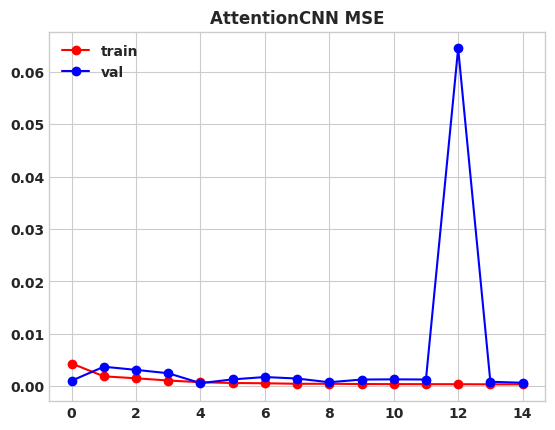

In [15]:
# plot history
plt.plot(history.history['loss'],'r-o', label='train')
plt.plot(history.history['val_loss'],'b-o', label='val')
plt.legend()
plt.title("AttentionCNN MSE" , weight='bold')
plt.show()

In [16]:
import sklearn.metrics as skm
from math import sqrt

def model_metrics(target: pd.DataFrame, predictions: []) -> None:
    print("Explained variance regression score: %.3f" %skm.explained_variance_score(target, predictions))
    print("Maximum residual error: %.3f" %skm.max_error(target, predictions))
    print("Mean squared error: %.3f" %skm.mean_squared_error(target, predictions))
    print("R2 Score: %.3f" %skm.r2_score(target, predictions))
    print("Root-mean-square Error: %.3f" %sqrt(skm.mean_squared_error(target, predictions)))
    print("Median_absolute_error: %.3f" %skm.median_absolute_error(target , predictions))
    print("Mean_absolute_error: %.3f" %skm.mean_absolute_error(target , predictions))

In [17]:
# Test Set 
yhat = model.predict(X_test)

709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [18]:
print("***  AttentionCNN Evaluation ***** ")
model_metrics(y_test , yhat)

***  AttentionCNN Evaluation ***** 
Explained variance regression score: 0.968
Maximum residual error: 0.236
Mean squared error: 0.001
R2 Score: 0.965
Root-mean-square Error: 0.025
Median_absolute_error: 0.008
Mean_absolute_error: 0.015


In [19]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5653e-04
Test Loss: 0.0006417077966034412


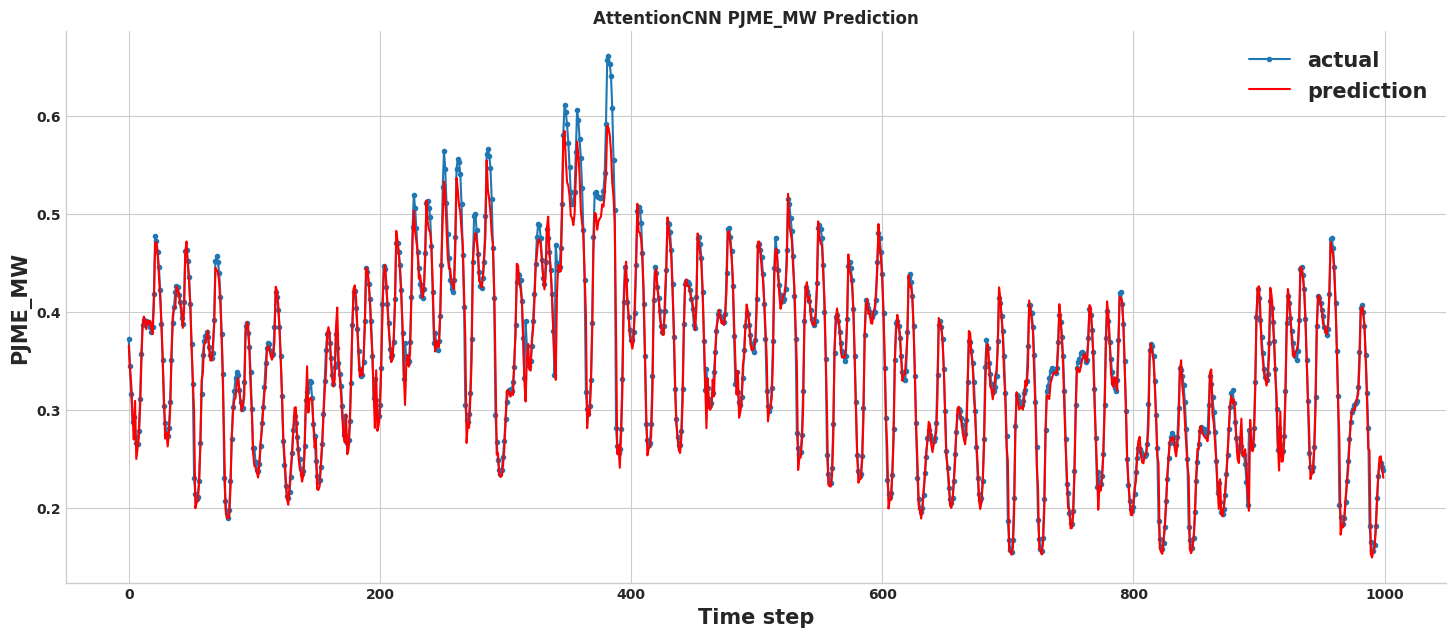

In [20]:
plt.figure(figsize=(15,6))
plt.plot( y_test[:1000], marker='.', label="actual")
plt.plot( yhat[:1000], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('PJME_MW', size=15 , weight='bold')
plt.xlabel('Time step', size=15 , weight='bold')
plt.legend(fontsize=15)
plt.title("AttentionCNN PJME_MW Prediction" , weight='bold')
plt.show();